In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns

from nilearn import plotting, image
from nilearn.masking import apply_mask
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from joblib import Memory, dump
from tempfile import mkdtemp
from my_sklearn_tools.model_selection import StratifiedKFoldReg
from sklearn.linear_model._coordinate_descent import _alpha_grid

/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


<IPython.core.display.Javascript object>

All subjects = 176
Subjects used = 145
Discarded subjects used = 31
../data/split_half_data/sub-%s/SplitHalf/ER_1stHalf/%s.nii
../data/split_half_data/sub-%s/SplitHalf/ER_2ndHalf/%s.nii


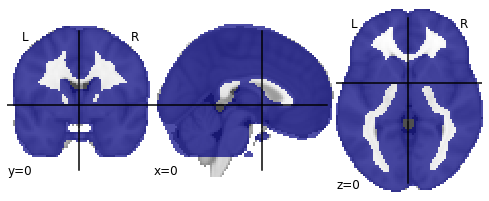

In [2]:
all_subjects = list(map(lambda x: int(x.split("sub-")[1]), os.listdir("../data/split_half_data/")))
print("All subjects = %d" % len(all_subjects))

final_subjects_used = pd.read_csv("../data/final_subjects_used.txt", header=None).iloc[:,0].to_list()
print("Subjects used = %d" % len(final_subjects_used))

discarded_subjects = list(set(all_subjects).difference(set(final_subjects_used)))
print("Discarded subjects used = %d" % len(discarded_subjects))

np.corrcoef(pd.read_csv("../data/target_data.csv").loc[:, "ePrime.id"].to_numpy(),
             final_subjects_used)

gm_mask = "../data/reslicedER_grey25grey25.nii" 
plotting.plot_roi(gm_mask, cut_coords=(0,0,0))
pass

# Name for each contrast in the files
lookneg_vs_lookneut = "con_0001"
regneg_vs_lookneg = "con_0002"

er_1_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_1stHalf/%s.nii"
print(er_1_half_pattern)

er_2_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_2ndHalf/%s.nii"
print(er_2_half_pattern)

# target data
Y_df = pd.read_csv("../data/target_data.csv")

In [3]:
def compute_phenotype(grid):
    V = grid.best_estimator_.named_steps['pca'].components_ # PCA transformation
    beta =  grid.best_estimator_.named_steps['lasso'].coef_ # Coefficients in the PC space
    insert_filtered_voxels = grid.best_estimator_.named_steps['variancethreshold'].inverse_transform
    w = V.T @ beta
    w = w[None,:]
    w = insert_filtered_voxels(w)
    return np.squeeze(w)

In [4]:
def internal_consistency(a,b):
    r = np.corrcoef(a,b)[0,1]
    r_corrected = (2*r)/(1+r)
    return r_corrected

# CASE 1: Look Negative vs Look Neutral -> chg_LNeg_LNur 

In [5]:
from sklearn.model_selection import LeaveOneOut
from joblib import load

contrast = lookneg_vs_lookneut

loo = LeaveOneOut()

dot_11, dot_21 = [],[]
i_fold=1
for _, test_index in tqdm(loo.split(np.zeros(len(final_subjects_used)))):
    leave_out_subject = final_subjects_used[test_index[0]]
    model = load("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/models/fold_%.3d.joblib" % i_fold)
    w = compute_phenotype(model)
    
    X_test_1 = apply_mask(er_1_half_pattern % (leave_out_subject, contrast), mask_img = gm_mask)
    dot_11.append(X_test_1.dot(w))
    
    X_test_2 = apply_mask(er_2_half_pattern % (leave_out_subject, contrast), mask_img = gm_mask)
    dot_21.append(X_test_2.dot(w))
    
    i_fold += 1

145it [00:48,  3.00it/s]


In [6]:
# Conservative way
sb_icc_whole = internal_consistency(dot_11, dot_21)
print("Spearman-Brown Internal Consistency " 
      "using the weights from the whole data: %.3f" % sb_icc_whole)

Spearman-Brown Internal Consistency using the weights from the whole data: 0.474


In [16]:
# Inflated case
X_half_11 = apply_mask([er_1_half_pattern % (subj, lookneg_vs_lookneut) for subj in final_subjects_used],
                       mask_img=gm_mask)
X_half_12 = apply_mask([er_2_half_pattern % (subj, lookneg_vs_lookneut) for subj in final_subjects_used],
                       mask_img=gm_mask)
w_full_1 = np.load("../results/phenotypes/chg_LNeg_LNur/look_neg_look_neut/decoding_weights.npy")
print("Spearman-Brown Internal Consistency " 
      "using the weights from the whole data: %.3f" % internal_consistency(X_half_11.dot(w_full_1), 
                                                                           X_half_12.dot(w_full_1)))

Spearman-Brown Internal Consistency using the weights from the whole data: 0.688


# CASE 2: Regulate Negative vs Look Negative -> chg_RNeg_LNeg 

In [18]:
from sklearn.model_selection import LeaveOneOut
from joblib import load

contrast = regneg_vs_lookneg

loo = LeaveOneOut()

dot_12, dot_22 = [],[]
i_fold=1
for _, test_index in tqdm(loo.split(np.zeros(len(final_subjects_used)))):
    leave_out_subject = final_subjects_used[test_index[0]]
    model = load("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/models/fold_%.3d.joblib" % i_fold)
    w = compute_phenotype(model)
    
    X_test_1 = apply_mask(er_1_half_pattern % (leave_out_subject, contrast), mask_img = gm_mask)
    dot_12.append(X_test_1.dot(w))
    
    X_test_2 = apply_mask(er_2_half_pattern % (leave_out_subject, contrast), mask_img = gm_mask)
    dot_22.append(X_test_2.dot(w))
    
    i_fold += 1

145it [01:06,  2.19it/s]


In [115]:
from sklearn.model_selection import LeaveOneOut
from joblib import load

contrast = regneg_vs_lookneg

loo = LeaveOneOut()

dot_12, dot_22 = [],[]
i_fold=1
for _, test_index in tqdm(loo.split(np.zeros(len(final_subjects_used)))):
    leave_out_subject = final_subjects_used[test_index[0]]
    model = load("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/models/fold_%.3d.joblib" % i_fold)
    w = compute_phenotype(model)
    
    X_test_1 = apply_mask(er_1_half_pattern % (leave_out_subject, contrast), mask_img = gm_mask)
    dot_12.append(X_test_1.dot(w))
    
    X_test_2 = apply_mask(er_2_half_pattern % (leave_out_subject, contrast), mask_img = gm_mask)
    dot_22.append(X_test_2.dot(w))
    
    i_fold += 1
#compute_phenotype(load("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/models/fold_001.joblib"))
#internal_consistency(X_test_1.dot(w), X_test_2.dot(w))

145it [04:38,  1.92s/it]


In [19]:
sb_icc_whole = internal_consistency(dot_12, dot_22)
print("Spearman-Brown Internal Consistency " 
      "using the weights from the whole data: %.3f" % sb_icc_whole)

Spearman-Brown Internal Consistency using the weights from the whole data: 0.390


In [20]:
# Inflated case
X_half_21 = apply_mask([er_1_half_pattern % (subj, regneg_vs_lookneg) for subj in final_subjects_used],
                       mask_img=gm_mask)
X_half_22 = apply_mask([er_2_half_pattern % (subj, regneg_vs_lookneg) for subj in final_subjects_used],
                       mask_img=gm_mask)
w_full_2 = np.load("../results/phenotypes/chg_RNeg_LNeg/reg_neg_look_neg/decoding_weights.npy")
print("Spearman-Brown Internal Consistency " 
      "using the weights from the whole data: %.3f" % internal_consistency(X_half_21.dot(w_full_2), 
                                                                           X_half_22.dot(w_full_2)))

Spearman-Brown Internal Consistency using the weights from the whole data: 0.858
